# A walkthrough of text analysis and TF-IDF

We'll start by using scikit-learn to count words, then come across some of the issues with simple word count analysis. Most of these problems can be tackled with TF-IDF - a single word might mean less in a longer text, and common words may contribute less to meaning than more rare ones.

<p class="reading-options">
  <a class="btn" href="/text-analysis/a-simple-explanation-of-tf-idf">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/A simple explanation of TF-IDF.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/A simple explanation of TF-IDF.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer

pd.options.display.max_columns = 30
%matplotlib inline

## Text analysis refresher

Text analysis has a few parts. We are going to use **bag of words** analysis, which just treats a sentence like a bag of words - no particular order or anything. It's simple but it usually gets the job done adequately.

Here is our text.

In [3]:
texts = [
    "Penny bought bright blue fishes.",
    "Penny bought bright blue and orange fish.",
    "The cat ate a fish at the store.",
    "Penny went to the store. Penny ate a bug. Penny saw a fish.",
    "It meowed once at the bug, it is still meowing at the bug and the fish",
    "The cat is at the fish store. The cat is orange. The cat is meowing at the fish.",
    "Penny is a fish"
]

When you process text, you have a nice long series of steps, but let's say you're interested in three things:

1. **Tokenizing** converts all of the sentences/phrases/etc into a series of words, and then it might also include converting it into a series of numbers - math stuff only works with numbers, not words. So maybe 'cat' is 2 and 'rug' is 4 and stuff like that.
2. **Counting** takes those words and sees how many there are (obviously) - how many times does `meow` appear?
3. **Normalizing** takes the count and makes new numbers - maybe it's how many times `meow` appears vs. how many total words there are, or maybe you're seeing how often `meow` comes up to see whether it's important.

In [4]:
"Penny bought bright blue fishes".split()

['Penny', 'bought', 'bright', 'blue', 'fishes']

      Penny bought bright blue fishes.

If we **tokenize** that sentence, we're just lowercasing it, removing the punctuation and splitting on spaces - `penny bought bright blue fishes`. It also works for other languages:

      у меня зазвонил телефон

That's Russian for "my phone is ringing." It works just as well with the tokenizer we used for English - lowercase it, remove punctuation, split on spaces. No big deal!

      私はえんぴつです。
  
This is Japanese for "I am a pencil." It *doesn't* work with our tokenizer, since it doesn't have spaces. You don't treat every character separately, either - `私` and `は` are their own thing, but `えんぴつ` means "pencil" and `です` is "to be."

"Eastern" languages need special tokenizing (and usually other treatment) when doing text analysis, mostly because they don't have spaces. They're collectively referred to as "CJK" languages, for Chinese, Japanese and Korean. It includes languages outside of those three, too, as long as they don't adhere to the "just make it lowercase and split on spaces" rules. You'll need to track down special tokenizers if you're working with those languages.


The `scikit-learn` package does a **ton of stuff**, some of which includes the above. We're going to start by playing with the `CountVectorizer`.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

In [6]:
# .fit_transfer TOKENIZES and COUNTS
X = count_vectorizer.fit_transform(texts)

Let's take a look at what it found out!

In [7]:
X

<7x23 sparse matrix of type '<class 'numpy.int64'>'
	with 49 stored elements in Compressed Sparse Row format>

Okay, that looks like trash and garbage. What's a "sparse array"??????

In [8]:
X.toarray()

array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 1, 1, 1],
       [1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 3, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0, 1, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=int64)

If we put on our **Computer Goggles** we see that the first sentence has the first word 3 times, the second word 1 time, the third word 1 time, etc... But we can't *read* it, really. It would look nicer as a dataframe.

In [9]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0
3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,3,1,0,1,1,1,1
4,1,2,0,0,0,0,2,0,1,0,1,2,1,1,1,0,0,0,1,0,3,0,0
5,0,2,0,0,0,0,0,3,2,0,3,0,0,1,0,1,0,0,0,1,5,0,0
6,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0


What do all of those numbers mean????

In [10]:
# Penny is a fish
# A fish is Penny
count_vectorizer.get_feature_names()

['and',
 'at',
 'ate',
 'blue',
 'bought',
 'bright',
 'bug',
 'cat',
 'fish',
 'fishes',
 'is',
 'it',
 'meowed',
 'meowing',
 'once',
 'orange',
 'penny',
 'saw',
 'still',
 'store',
 'the',
 'to',
 'went']

In [11]:
pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())

,and,at,ate,blue,bought,bright,bug,cat,fish,fishes,is,it,meowed,meowing,once,orange,penny,saw,still,store,the,to,went
0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0
3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,3,1,0,1,1,1,1
4,1,2,0,0,0,0,2,0,1,0,1,2,1,1,1,0,0,0,1,0,3,0,0
5,0,2,0,0,0,0,0,3,2,0,3,0,0,1,0,1,0,0,0,1,5,0,0
6,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0


So sentence #4 has "at" once, and the first sentence has "bought" once, and the last sentence has "the" three times. But hey, those are garbage words! They're cluttering up our dataframe! We need to add **stopwords!**

In [12]:
# We'll make a new vectorizer
count_vectorizer = CountVectorizer(stop_words='english')
#count_vectorizer = CountVectorizer(stop_words=['the', 'and'])
# .fit_transfer TOKENIZES and COUNTS
X = count_vectorizer.fit_transform(texts)
print(count_vectorizer.get_feature_names())

['ate', 'blue', 'bought', 'bright', 'bug', 'cat', 'fish', 'fishes', 'meowed', 'meowing', 'orange', 'penny', 'saw', 'store', 'went']


In [13]:
pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())

,ate,blue,bought,bright,bug,cat,fish,fishes,meowed,meowing,orange,penny,saw,store,went
0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0
2,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0,0,0,0,3,1,1,1
4,0,0,0,0,2,0,1,0,1,1,0,0,0,0,0
5,0,0,0,0,0,3,2,0,0,1,1,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


I still see `meowed` and `meowing` and `fish` and `fishes` - they seem the same, so let's lemmatize/stem them.

You can specify a `preprocessor` or a `tokenizer` when you're creating your `CountVectorizer` to do custom *stuff* on your words. Maybe we want to get rid of punctuation, lowercase things and split them on spaces (this is basically the default). `preprocessor` is supposed to return a string, so it's a little easier to work with.

In [14]:
# This is what our normal tokenizer looks like
def boring_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    return words

count_vectorizer = CountVectorizer(stop_words='english', tokenizer=boring_tokenizer)
X = count_vectorizer.fit_transform(texts)
print(count_vectorizer.get_feature_names())

['ate', 'blue', 'bought', 'bright', 'bug', 'cat', 'fish', 'fishes', 'meowed', 'meowing', 'orange', 'penny', 'saw', 'store', 'went']


We're going to use one that features a **stemmer** - something that strips the endings off of words (or tries to, at least). This one is from `nltk`.

In [15]:
# https://tartarus.org/martin/PorterStemmer/def.txt
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

print(porter_stemmer.stem('fishes'))
print(porter_stemmer.stem('meowed'))
print(porter_stemmer.stem('oranges'))
print(porter_stemmer.stem('meowing'))
print(porter_stemmer.stem('orange'))
print(porter_stemmer.stem('go'))
print(porter_stemmer.stem('went'))

fish
meow
orang
meow
orang
go
went


In [17]:
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

count_vectorizer = CountVectorizer(stop_words='english', tokenizer=stemming_tokenizer)
X = count_vectorizer.fit_transform(texts)
print(count_vectorizer.get_feature_names())

['ate', 'blue', 'bought', 'bright', 'bug', 'cat', 'fish', 'meow', 'onc', 'orang', 'penni', 'saw', 'store', 'went']


Now lets look at the new version of that dataframe.

In [18]:
pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0,1,1,1,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,0,1,0,0,1,1,0,0,0
2,1,0,0,0,0,1,1,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0,0,0,3,1,1,1
4,0,0,0,0,2,0,1,2,1,0,0,0,0,0
5,0,0,0,0,0,3,2,1,0,1,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,1,0,0,0


    "Penny bought bright blue fishes.",
    "Penny bought bright blue and orange fish.",
    "The cat ate a fish at the store.",
    "Penny went to the store. Penny ate a bug. Penny saw a fish.",
    "It meowed once at the bug, it is still meowing at the bug and the fish",
    "The cat is at the fish store. The cat is orange. The cat is meowing at the fish.",
    "Penny is a fish"

## TF-IDF

### Part One: Term Frequency

TF-IDF? What? It means **term frequency inverse document frequency!** It's the most important thing. Let's look at our list of phrases

1. Penny bought bright blue fishes.
2. Penny bought bright blue and orange fish.
3. The cat ate a fish at the store.
4. Penny went to the store. Penny ate a bug. Penny saw a fish.
5. It meowed once at the fish, it is still meowing at the fish. It meowed at the bug and the fish.
6. The cat is fat. The cat is orange. The cat is meowing at the fish.
7. Penny is a fish

If we're searching for the word `fish`, which is the most helpful phrase?

In [19]:
pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0,1,1,1,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,0,1,0,0,1,1,0,0,0
2,1,0,0,0,0,1,1,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0,0,0,3,1,1,1
4,0,0,0,0,2,0,1,2,1,0,0,0,0,0
5,0,0,0,0,0,3,2,1,0,1,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,1,0,0,0


Probably the one where `fish` appears three times.

    It meowed once at the fish, it is still meowing at the fish. It meowed at the bug and the fish.
    
But are all the others the same?

    Penny is a fish.

    Penny went to the store. Penny ate a bug. Penny saw a fish.

In the second one we spend less time talking about the fish. Think about a huge long document where they say your name once, versus a tweet where they say your name once. Which one are you more important in? Probably the tweet, since you take up a larger percentage of the text.

This is **term frequency** - taking into account how often a term shows up. We're going to take this into account by using the `TfidfVectorizer` in the same way we used the `CountVectorizer`.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=False, norm='l1')
X = tfidf_vectorizer.fit_transform(texts)
pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0.000000,0.200000,0.200000,0.200000,0.000000,0.000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
1,0.000000,0.166667,0.166667,0.166667,0.000000,0.000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000
2,0.250000,0.000000,0.000000,0.000000,0.000000,0.250,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
3,0.111111,0.000000,0.000000,0.000000,0.111111,0.000,0.111111,0.000000,0.000000,0.000000,0.333333,0.111111,0.111111,0.111111
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.000,0.166667,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.375,0.250000,0.125000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000


Now our numbers have shifted a little bit. Instead of just being a count, it's *the percentage of the words*.

    value = (number of times word appears in sentence) / (number of words in sentence)

After we remove the stopwords, the term `fish` is 50% of the words in `Penny is a fish` vs. 37.5% in `It meowed once at the fish, it is still meowing at the fish. It meowed at the bug and the fish.`.

> **Note:** We made it be the percentage of the words by passing in `norm="l1"` - by default it's normally an L2 (Euclidean) norm, which is actually better, but I thought it would make more sense using the L1 - a.k.a. terms divided by words -norm.

So now when we search we'll get **more relevant results** because it takes into account whether half of our words are `fish` or 1% of millions upon millions of words is `fish`. But we aren't done yet!

### Part Two: Inverse document frequency

Let's say we're searching for "fish meow"

In [22]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=False, norm='l1')
X = tfidf_vectorizer.fit_transform(texts)
df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
df

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0.000000,0.200000,0.200000,0.200000,0.000000,0.000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
1,0.000000,0.166667,0.166667,0.166667,0.000000,0.000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000
2,0.250000,0.000000,0.000000,0.000000,0.000000,0.250,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
3,0.111111,0.000000,0.000000,0.000000,0.111111,0.000,0.111111,0.000000,0.000000,0.000000,0.333333,0.111111,0.111111,0.111111
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.000,0.166667,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.375,0.250000,0.125000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000


What's the highest combined? for 'fish' and 'meow'?

In [23]:
# Just add the columns together
pd.DataFrame([df['fish'], df['meow'], df['fish'] + df['meow']], index=["fish", "meow", "fish + meow"]).T

,fish,meow,fish + meow
0,0.200000,0.000000,0.200000
1,0.166667,0.000000,0.166667
2,0.250000,0.000000,0.250000
3,0.111111,0.000000,0.111111
4,0.166667,0.333333,0.500000
5,0.250000,0.125000,0.375000
6,0.500000,0.000000,0.500000


Indices 4 and 6 (numbers 5 and 7) are tied - but meow never even appears in one of them!

    It meowed once at the bug, it is still meowing at the bug and the fish
    Penny is a fish

It seems like since `fish` shows up again and again it should be weighted a little less - not like it's a *stopword*, but just... it's kind of cliche to have it show up in the text, so we want to make it less important.

This is **inverse term frequency** - the more often a term shows up across *all* documents, the less important it is in our matrix.

In [24]:
# use_idf=True is default, but I'll leave it in
idf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=True, norm='l1')
X = idf_vectorizer.fit_transform(texts)
idf_df = pd.DataFrame(X.toarray(), columns=idf_vectorizer.get_feature_names())
idf_df

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0.000000,0.235463,0.235463,0.235463,0.000000,0.000000,0.118871,0.000000,0.000000,0.000000,0.174741,0.000000,0.000000,0.000000
1,0.000000,0.190587,0.190587,0.190587,0.000000,0.000000,0.096216,0.000000,0.000000,0.190587,0.141437,0.000000,0.000000,0.000000
2,0.297654,0.000000,0.000000,0.000000,0.000000,0.297654,0.150267,0.000000,0.000000,0.000000,0.000000,0.000000,0.254425,0.000000
3,0.125073,0.000000,0.000000,0.000000,0.125073,0.000000,0.063142,0.000000,0.000000,0.000000,0.278455,0.150675,0.106908,0.150675
4,0.000000,0.000000,0.000000,0.000000,0.350291,0.000000,0.088420,0.350291,0.210997,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.437035,0.147088,0.145678,0.000000,0.145678,0.000000,0.000000,0.124521,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.404858,0.000000,0.000000,0.000000,0.595142,0.000000,0.000000,0.000000


Let's take a look at our OLD values, then our NEW values, just for `meow` and `fish`.

In [25]:
# OLD dataframe
pd.DataFrame([df['fish'], df['meow'], df['fish'] + df['meow']], index=["fish", "meow", "fish + meow"]).T

,fish,meow,fish + meow
0,0.200000,0.000000,0.200000
1,0.166667,0.000000,0.166667
2,0.250000,0.000000,0.250000
3,0.111111,0.000000,0.111111
4,0.166667,0.333333,0.500000
5,0.250000,0.125000,0.375000
6,0.500000,0.000000,0.500000


In [26]:
# NEW dataframe
pd.DataFrame([idf_df['fish'], idf_df['meow'], idf_df['fish'] + idf_df['meow']], index=["fish", "meow", "fish + meow"]).T

,fish,meow,fish + meow
0,0.118871,0.000000,0.118871
1,0.096216,0.000000,0.096216
2,0.150267,0.000000,0.150267
3,0.063142,0.000000,0.063142
4,0.088420,0.350291,0.438712
5,0.147088,0.145678,0.292766
6,0.404858,0.000000,0.404858


Notice how 'meow' increased in value because it's an infrequent term, and `fish` dropped in value because it's so frequent.

That meowing one (index 4) has gone from `0.50` to `0.43`, while `Penny is a fish` (index 6) has dropped to `0.40`. Now hooray, the meowing one is going to show up earlier when searching for "fish meow" because *fish shows up all of the time, so we want to ignore it a lil' bit*.

But honestly **I wasn't very impressed by that drop.**

And this is why defaults are important: let's try changing it to `norm='l2'` (or just removing `norm` completely).

In [27]:
# use_idf=True is default, but I'll leave it in
l2_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=True)
X = l2_vectorizer.fit_transform(texts)
l2_df = pd.DataFrame(X.toarray(), columns=l2_vectorizer.get_feature_names())
l2_df

,ate,blue,bought,bright,bug,cat,fish,meow,onc,orang,penni,saw,store,went
0,0.000000,0.512612,0.512612,0.512612,0.000000,0.000000,0.258786,0.000000,0.000000,0.000000,0.380417,0.000000,0.000000,0.000000
1,0.000000,0.456170,0.456170,0.456170,0.000000,0.000000,0.230292,0.000000,0.000000,0.456170,0.338530,0.000000,0.000000,0.000000
2,0.578752,0.000000,0.000000,0.000000,0.000000,0.578752,0.292176,0.000000,0.000000,0.000000,0.000000,0.000000,0.494698,0.000000
3,0.303663,0.000000,0.000000,0.000000,0.303663,0.000000,0.153301,0.000000,0.000000,0.000000,0.676058,0.365821,0.259561,0.365821
4,0.000000,0.000000,0.000000,0.000000,0.641958,0.000000,0.162043,0.641958,0.386682,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.840166,0.282766,0.280055,0.000000,0.280055,0.000000,0.000000,0.239382,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562463,0.000000,0.000000,0.000000,0.826823,0.000000,0.000000,0.000000


In [28]:
# normal TF-IDF dataframe
pd.DataFrame([idf_df['fish'], idf_df['meow'], idf_df['fish'] + idf_df['meow']], index=["fish", "meow", "fish + meow"]).T

,fish,meow,fish + meow
0,0.118871,0.000000,0.118871
1,0.096216,0.000000,0.096216
2,0.150267,0.000000,0.150267
3,0.063142,0.000000,0.063142
4,0.088420,0.350291,0.438712
5,0.147088,0.145678,0.292766
6,0.404858,0.000000,0.404858


In [29]:
# L2 norm TF-IDF dataframe
pd.DataFrame([l2_df['fish'], l2_df['meow'], l2_df['fish'] + l2_df['meow']], index=["fish", "meow", "fish + meow"]).T

,fish,meow,fish + meow
0,0.258786,0.000000,0.258786
1,0.230292,0.000000,0.230292
2,0.292176,0.000000,0.292176
3,0.153301,0.000000,0.153301
4,0.162043,0.641958,0.804000
5,0.282766,0.280055,0.562821
6,0.562463,0.000000,0.562463


**LOOK AT HOW IMPORTANT MEOW IS**. Meowing is out of this world important, because *no one ever meows*.

## Who cares? Why do we need to know this?

When someone dumps 100,000 documents on your desk in response to FOIA, you'll start to care! One of the reasons understanding **TF-IDF** is important is because of **document similarity**. By knowing what documents are similar you're able to find related documents and automatically group documents into clusters.

For example! Let's cluster these documents using K-Means clustering (check out [this gif](http://practicalcryptography.com/media/miscellaneous/files/k_mean_send.gif))

### 2 categories of documents

In [30]:
# Initialize a vectorizer
vectorizer = TfidfVectorizer(use_idf=True, tokenizer=stemming_tokenizer, stop_words='english')
X = vectorizer.fit_transform(texts)

In [31]:
X

<7x14 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [32]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.512612,0.512612,0.512612,0.000000,0.000000,0.258786,0.000000,0.000000,0.000000,0.380417,0.000000,0.000000,0.000000
1,0.000000,0.456170,0.456170,0.456170,0.000000,0.000000,0.230292,0.000000,0.000000,0.456170,0.338530,0.000000,0.000000,0.000000
2,0.578752,0.000000,0.000000,0.000000,0.000000,0.578752,0.292176,0.000000,0.000000,0.000000,0.000000,0.000000,0.494698,0.000000
3,0.303663,0.000000,0.000000,0.000000,0.303663,0.000000,0.153301,0.000000,0.000000,0.000000,0.676058,0.365821,0.259561,0.365821
4,0.000000,0.000000,0.000000,0.000000,0.641958,0.000000,0.162043,0.641958,0.386682,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.840166,0.282766,0.280055,0.000000,0.280055,0.000000,0.000000,0.239382,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562463,0.000000,0.000000,0.000000,0.826823,0.000000,0.000000,0.000000


In [33]:
# KMeans clustering is a method of clustering.
from sklearn.cluster import KMeans

number_of_clusters = 2
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [34]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: penni fish bright bought blue
Cluster 1: cat meow fish store bug


In [35]:
km.labels_

array([0, 0, 1, 0, 1, 1, 0], dtype=int32)

In [36]:
texts

['Penny bought bright blue fishes.',
 'Penny bought bright blue and orange fish.',
 'The cat ate a fish at the store.',
 'Penny went to the store. Penny ate a bug. Penny saw a fish.',
 'It meowed once at the bug, it is still meowing at the bug and the fish',
 'The cat is at the fish store. The cat is orange. The cat is meowing at the fish.',
 'Penny is a fish']

In [37]:
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_
results

,text,category
0,Penny bought bright blue fishes.,0
1,Penny bought bright blue and orange fish.,0
2,The cat ate a fish at the store.,1
3,Penny went to the store. Penny ate a bug. Penn...,0
4,"It meowed once at the bug, it is still meowing...",1
5,The cat is at the fish store. The cat is orang...,1
6,Penny is a fish,0


### 4 categories of documents

In [38]:
from sklearn.cluster import KMeans

number_of_clusters = 3
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [39]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: cat store ate fish orang
Cluster 1: bright bought blue penni fish
Cluster 2: penni bug fish meow onc


In [40]:
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_
results

,text,category
0,Penny bought bright blue fishes.,1
1,Penny bought bright blue and orange fish.,1
2,The cat ate a fish at the store.,0
3,Penny went to the store. Penny ate a bug. Penn...,2
4,"It meowed once at the bug, it is still meowing...",2
5,The cat is at the fish store. The cat is orang...,0
6,Penny is a fish,2


## Visualizing text similarity

In [41]:
texts = ['Penny bought bright blue fishes.',
 'Penny bought bright blue and orange bowl.',
 'The cat ate a fish at the store.',
 'Penny went to the store. Penny ate a bug. Penny saw a fish.',
 'It meowed once at the bug, it is still meowing at the bug and the fish',
 'The cat is at the fish store. The cat is orange. The cat is meowing at the fish.',
 'Penny is a fish.',
 'Penny Penny she loves fishes Penny Penny is no cat.',
 'The store is closed now.',
 'How old is that tree?',
 'I do not eat fish I do not eat cats I only eat bugs']


# Initialize a vectorizer
vectorizer = TfidfVectorizer(use_idf=True, max_features=2, tokenizer=stemming_tokenizer, stop_words='english')
X = vectorizer.fit_transform(texts)

In [42]:
vectorizer.get_feature_names()

['fish', 'penni']

In [43]:
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df

,fish,penni
0,0.605349,0.795961
1,0.000000,1.000000
2,1.000000,0.000000
3,0.245735,0.969337
4,1.000000,0.000000
5,1.000000,0.000000
6,0.605349,0.795961
7,0.186785,0.982401
8,0.000000,0.000000
9,0.000000,0.000000


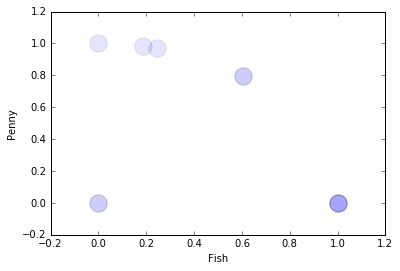

In [44]:
ax = df.plot(kind='scatter', x='fish', y='penni', alpha=0.1, s=300)
ax.set_xlabel("Fish")
ax.set_ylabel("Penny")

In [45]:
from sklearn.cluster import KMeans

number_of_clusters = 3
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)
df['category'] = km.labels_

In [46]:
df

,fish,penni,category
0,0.605349,0.795961,1
1,0.000000,1.000000,1
2,1.000000,0.000000,0
3,0.245735,0.969337,1
4,1.000000,0.000000,0
5,1.000000,0.000000,0
6,0.605349,0.795961,1
7,0.186785,0.982401,1
8,0.000000,0.000000,2
9,0.000000,0.000000,2


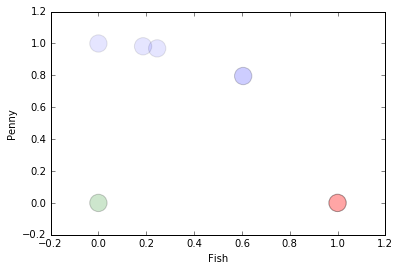

In [47]:
color_list = ['r', 'b', 'g', 'y']
colors = [color_list[i] for i in df['category']]

ax = df.plot(kind='scatter', x='fish', y='penni', alpha=0.1, s=300, c=colors)
ax.set_xlabel("Fish")
ax.set_ylabel("Penny")

In [48]:
# Initialize a vectorizer
vectorizer = TfidfVectorizer(use_idf=True, max_features=3, tokenizer=stemming_tokenizer, stop_words='english')
X = vectorizer.fit_transform(texts)

In [49]:
vectorizer.get_feature_names()

['cat', 'fish', 'penni']

In [50]:
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df

,cat,fish,penni
0,0.000000,0.605349,0.795961
1,0.000000,0.000000,1.000000
2,0.824391,0.566020,0.000000
3,0.000000,0.245735,0.969337
4,0.000000,1.000000,0.000000
5,0.909273,0.416200,0.000000
6,0.000000,0.605349,0.795961
7,0.262506,0.180235,0.947948
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


In [51]:
from sklearn.cluster import KMeans

number_of_clusters = 4
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)
df['category'] = km.labels_

In [52]:
df['text'] = texts
df

,cat,fish,penni,category,text
0,0.000000,0.605349,0.795961,1,Penny bought bright blue fishes.
1,0.000000,0.000000,1.000000,1,Penny bought bright blue and orange bowl.
2,0.824391,0.566020,0.000000,0,The cat ate a fish at the store.
3,0.000000,0.245735,0.969337,1,Penny went to the store. Penny ate a bug. Penn...
4,0.000000,1.000000,0.000000,3,"It meowed once at the bug, it is still meowing..."
5,0.909273,0.416200,0.000000,0,The cat is at the fish store. The cat is orang...
6,0.000000,0.605349,0.795961,1,Penny is a fish.
7,0.262506,0.180235,0.947948,1,Penny Penny she loves fishes Penny Penny is no...
8,0.000000,0.000000,0.000000,2,The store is closed now.
9,0.000000,0.000000,0.000000,2,How old is that tree?


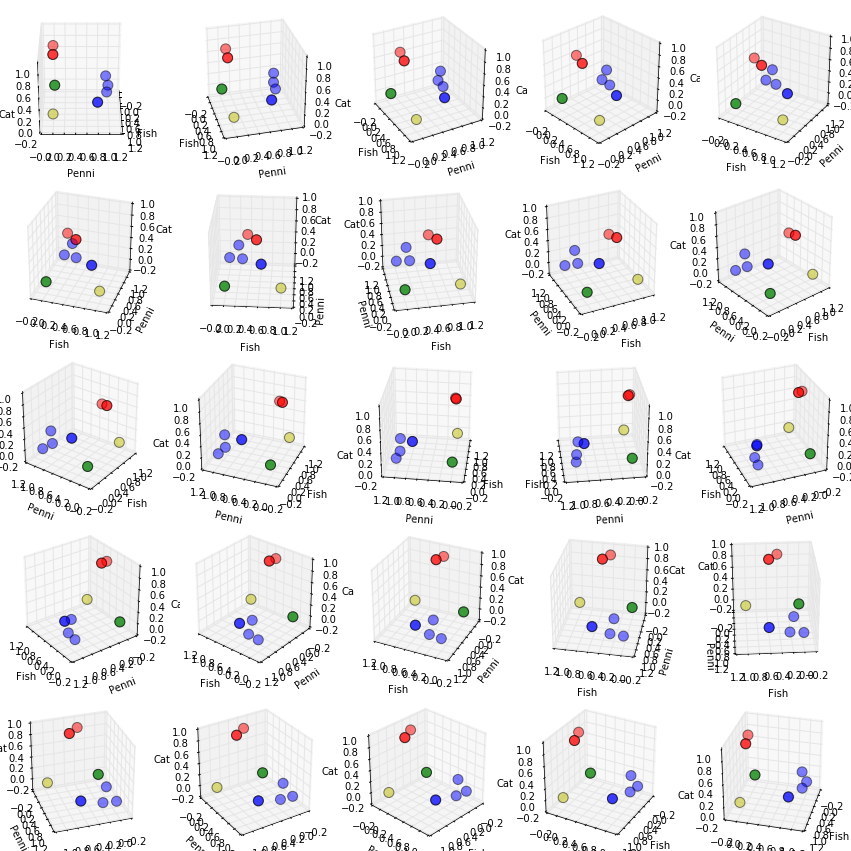

In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw(ax, df):
    color_list = ['r', 'b', 'g', 'y']
    colors = [color_list[i] for i in df['category']]

    marker_list = ['o', 'x', 'v', 'X']
    markers = [marker_list[i] for i in df['category']]

    ax.scatter(df['fish'], df['penni'], df['cat'], c=colors, s=100, alpha=0.5)
    ax.set_xlabel('Fish')
    ax.set_ylabel('Penni')
    ax.set_zlabel('Cat')

chart_count_vert = 5
chart_count_horiz = 5
number_of_graphs = chart_count_vert * chart_count_horiz

fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

for i in range(number_of_graphs):
    ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
    draw(ax, df)